In [1]:
# Instalando pacotes

!pip install keras
!pip install tensorflow
!pip install statsmodels
!pip install sklearn
!pip install matplotlib
!pip install pmdarima
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install datetime
!pip install statsmodels
!pip install ipeadatapy

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates from a subpr

In [1]:
# Importando pacotes

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from pmdarima import arima
from pmdarima.arima import auto_arima
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from matplotlib.pyplot import rcParams
rcParams['figure.figsize']=15,6
from pmdarima.arima import ADFTest
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.utils import tsdisplay, autocorr_plot, decomposed_plot, plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
#import matplotlib.dates as mdates
import statsmodels.api as sm
from scipy.stats import kstest
import ipeadatapy as ip
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
# Utiliando a API do IPEADATA para trazer as informações da produção do papelão ondulado

ip.metadata('ABPO12_PAPEL12')

,CODE,NAME,COMMENT,LAST UPDATE,BIG THEME,SOURCE ACRONYM,SOURCE,SOURCE URL,FREQUENCY,MEASURE,UNIT,SERIES STATUS,THEME CODE,COUNTRY,NUMERICA
0,ABPO12_PAPEL12,"Papelão ondulado - expedição de caixas, acessó...",O papelão ondulado é um material 100% produzid...,2025-08-12T12:19:32.237-03:00,Macroeconômico,ABPO,"Associação Brasileira do Papelão Ondulado, Bol...",www.abpo.org.br,Mensal,Tonelada,None,A,1,BRA,True


In [5]:
# Convertendo em um dataframe

df = ip.timeseries('ABPO12_PAPEL12')
df = pd.DataFrame(df)
df.head()
        

,CODE,RAW DATE,DAY,MONTH,YEAR,VALUE (Tonelada)
DATE,,,,,,
1980-01-01,ABPO12_PAPEL12,1980-01-01T00:00:00-02:00,1,1,1980,89659.629742
1980-02-01,ABPO12_PAPEL12,1980-02-01T00:00:00-02:00,1,2,1980,83332.390441
1980-03-01,ABPO12_PAPEL12,1980-03-01T00:00:00-03:00,1,3,1980,89123.613617
1980-04-01,ABPO12_PAPEL12,1980-04-01T00:00:00-03:00,1,4,1980,85477.704398
1980-05-01,ABPO12_PAPEL12,1980-05-01T00:00:00-03:00,1,5,1980,91161.474458


In [7]:
# Recorte temporal para estimar os parâmetros

data = pd.Series(df.iloc[:, 5].values.round(2),
                    index=pd.date_range(start='1980-01-01', periods=len(df), freq='ME'))

papelao = data.loc['1980-01-01':'2024-12-31']

papelao.head()
            

1980-01-31    89659.63
1980-02-29    83332.39
1980-03-31    89123.61
1980-04-30    85477.70
1980-05-31    91161.47
Freq: ME, dtype: float64

In [9]:
# Análise descritiva

papelao.describe().round(2)

count       540.00
mean     202315.82
std       89082.83
min       51671.20
25%      112088.90
50%      210899.86
75%      279995.50
max      391160.00
dtype: float64

In [11]:
# Ajuste na coluna

papelao.name = "Produção Papelão"
papelao

1980-01-31     89659.63
1980-02-29     83332.39
1980-03-31     89123.61
1980-04-30     85477.70
1980-05-31     91161.47
                ...    
2024-08-31    376204.00
2024-09-30    353766.00
2024-10-31    391160.00
2024-11-30    365395.00
2024-12-31    313487.00
Freq: ME, Name: Produção Papelão, Length: 540, dtype: float64

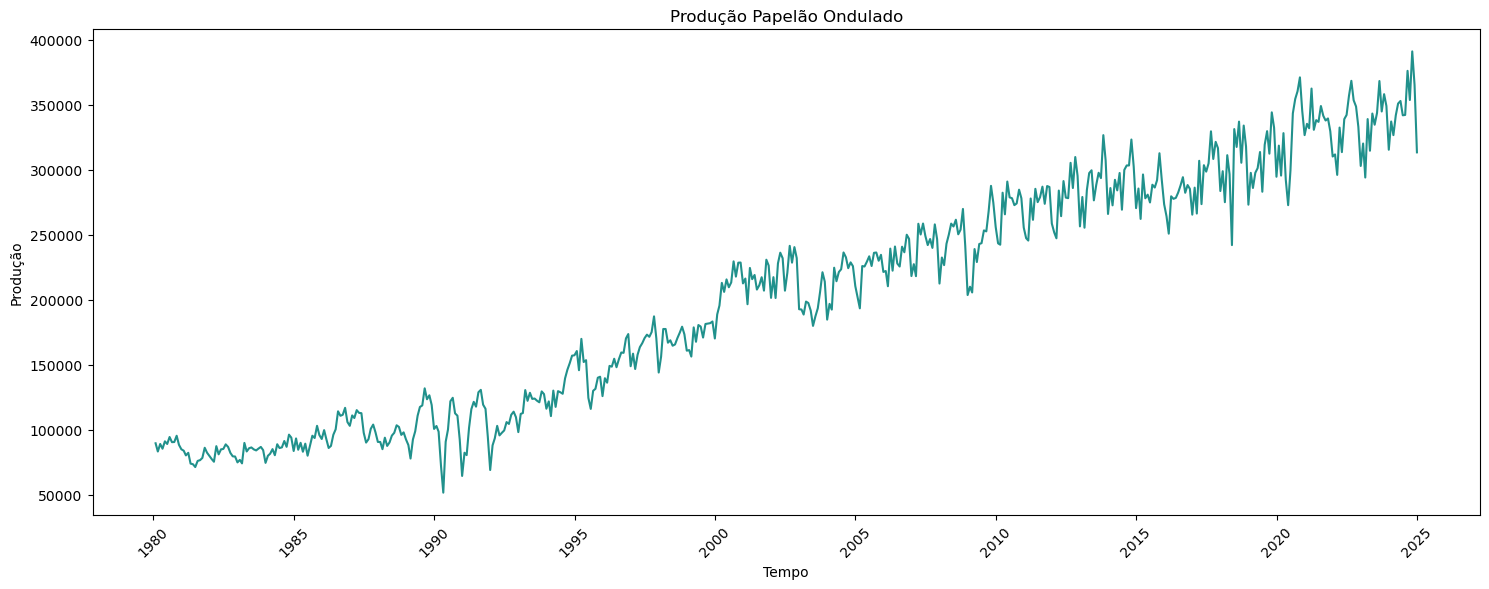

In [13]:
# Plotando o grafico

viridis_map = plt.get_cmap('viridis')
cor_viridis = viridis_map(0.5)

plt.figure(figsize=(15,6))
plt.plot(papelao,color=cor_viridis)
plt.title("Produção Papelão Ondulado")
plt.xlabel("Tempo")
plt.ylabel("Produção")
ax = plt.gca()
plt.xticks(rotation=45)  # Rotaciona as datas para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar cortes nas labels
plt.show()
             

In [15]:
# Utilizando o seasonal_decompose no modelo aditivo para obervar o comportamento da séire.

resultado = seasonal_decompose(data, model='additive')

Text(0, 0.5, 'Resíduo')

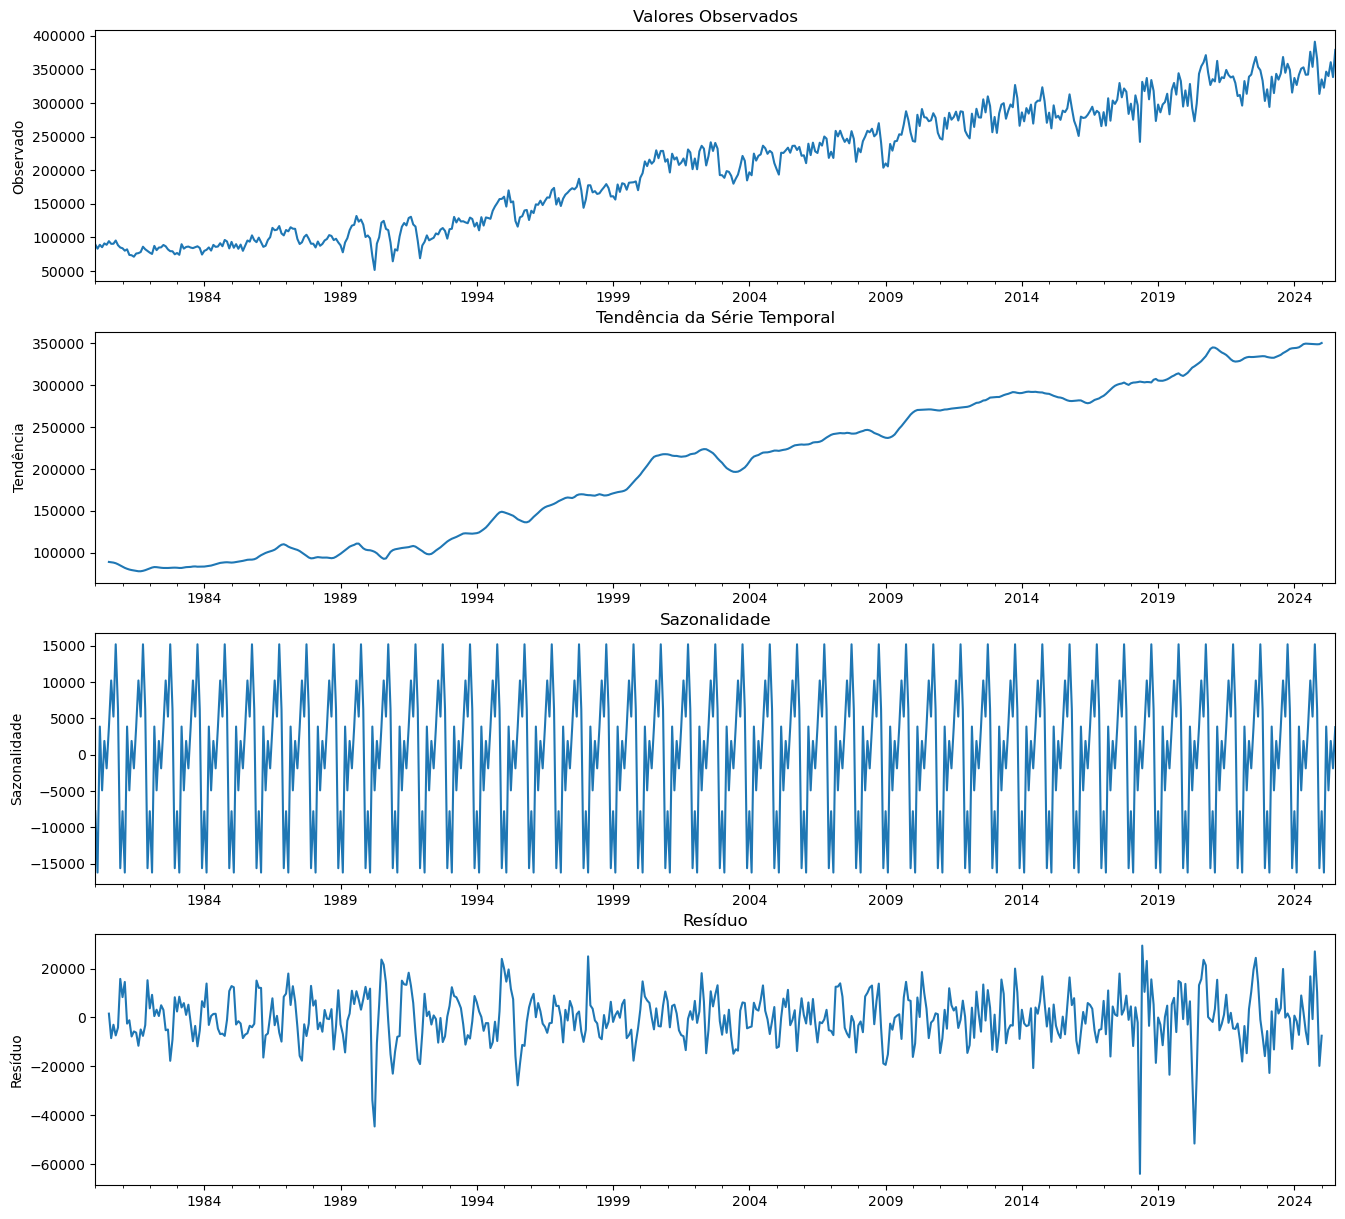

In [17]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 15))

resultado.observed.plot(ax=ax1)
ax1.set_title('Valores Observados')
ax1.set_ylabel('Observado')

resultado.trend.plot(ax=ax2)
ax2.set_title('Tendência da Série Temporal')
ax2.set_ylabel('Tendência')

resultado.seasonal.plot(ax=ax3)
ax3.set_title('Sazonalidade')
ax3.set_ylabel('Sazonalidade')

resultado.resid.plot(ax=ax4)
ax4.set_title('Resíduo')
ax4.set_ylabel('Resíduo')

C:\Users\Rafael\anaconda3\Lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


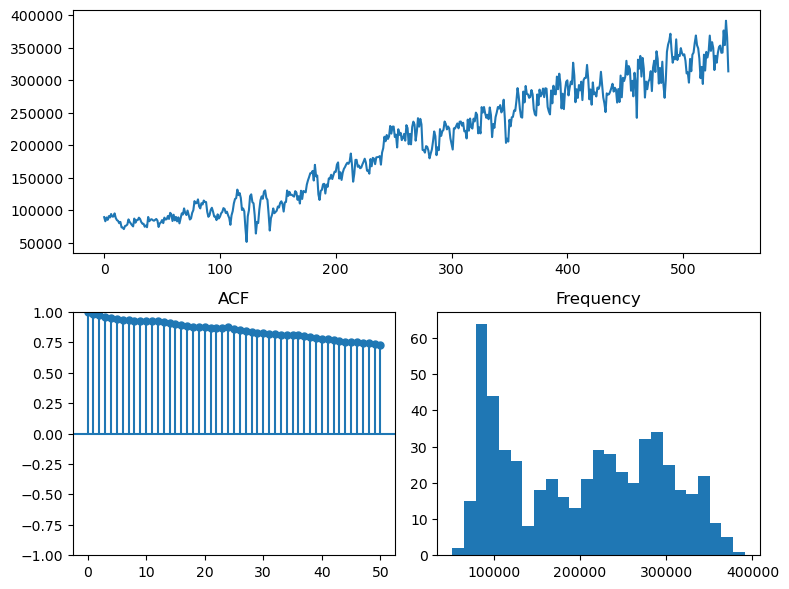

In [19]:
# Outra visão

tsdisplay(papelao)

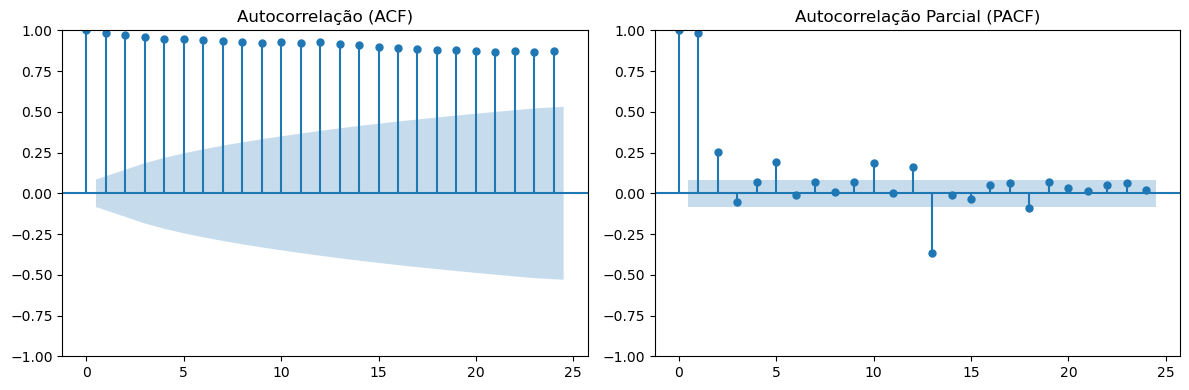

In [21]:
# ACF (Função de Autocorrelação) e PACF (Função de Autocorrelação Parcial) - Não Estacionaria

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plotando o ACF no primeiro subplot
plot_acf(papelao,lags=24,alpha=0.05, ax=ax1)
ax1.set_title('Autocorrelação (ACF)')

# Plotando o PACF no segundo subplot
pacf_values = pacf(papelao, nlags=24,alpha=0.05)
plot_pacf(papelao,lags=24,alpha=0.05, ax=ax2)
ax2.set_title('Autocorrelação Parcial (PACF)')

plt.tight_layout()
plt.show()

In [23]:
# Teste Dickey-Fuller para verificar a estacionariedade da série

resultado_adf = adfuller(papelao.dropna())
print(f"Estatística ADF: {resultado_adf[0]}")
print(f'Resultado do Teste ADF: p-valor = {resultado_adf[1]}')
if resultado_adf[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

Estatística ADF: 0.07098893271489524
Resultado do Teste ADF: p-valor = 0.9640236383361994
A série não é estacionária.


In [27]:
# Estacionarização da Série - Dickey-Fuller

def estacionarizar_serie(papelao, alpha=0.05):

    p_valor = 1.0  # Inicializa o p-valor como maior que alpha
    n_diffs = 0    # Contador de diferenciações
    variavel_diferenciada = papelao.copy()

    while p_valor > alpha:
        # Aplicar diferenciação
        variavel_diferenciada = variavel_diferenciada.diff().dropna()
        n_diffs += 1

        # Realizar o teste ADF
        resultado_adf = adfuller(variavel_diferenciada)
        p_valor = resultado_adf[1]
        print(f"Diferenciação {n_diffs}: p-valor = {p_valor}")

    return variavel_diferenciada, n_diffs

variavel_estacionarizada, numero_diferenciacoes = estacionarizar_serie(papelao)
print(f"Série estacionarizada após {numero_diferenciacoes} diferenciação(ões).")

Diferenciação 1: p-valor = 1.897095107298238e-11
Série estacionarizada após 1 diferenciação(ões).


In [65]:
# Autoarima para escolhe dos parâmetros

modelo = auto_arima(papelao,
                    start_p=0,
                    start_q=0,
                    d=0,
                    max_p=10,
                    max_q=10,
                    max_d=2,
                    start_P=1,
                    start_Q=1,
                    D=1,
                    max_P=2, max_D=1, max_Q=2, max_order=5,
                    m=12,
                    seasonal=True,
                    trace=True,
                    error_action='ignore',suppress_warnings=True,
                    stepwise=True)

print(modelo.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=11725.041, Time=0.63 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=11845.959, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=11443.914, Time=0.43 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=11568.008, Time=0.43 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=11898.509, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=11560.430, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=11437.511, Time=0.88 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=11377.844, Time=1.66 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=11376.751, Time=0.74 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=11376.846, Time=0.49 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=11378.583, Time=2.02 sec
 ARIMA(1,0,0)(0,1,2)[12] intercept   : AIC=11376.738, Time=1.33 sec
 ARIMA(0,0,0)(0,1,2)[12] intercept   : AIC=11730.195, Time=0.88 sec
 ARIMA(2,0,0)(0,1,2)[12] intercept   : AIC=11364.305, Time=1.28 sec
 ARIM

In [66]:
# Divisão em 70% de treino e 30% teste.

tamanho_treino = int(len(papelao) * 0.7)
x_train = papelao[:tamanho_treino]
x_test = papelao[tamanho_treino:]

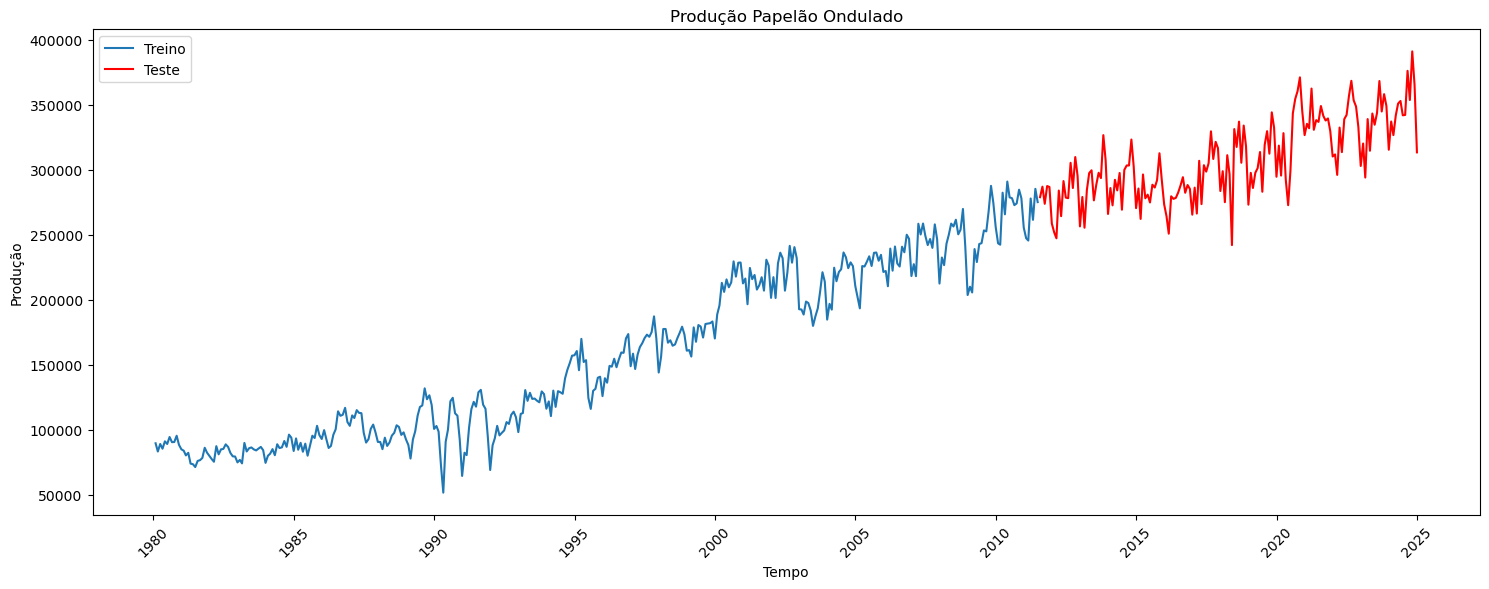

In [67]:
# Gráfico de treino e teste

plt.figure(figsize=(15,6))
plt.plot(x_train.index, x_train, label= 'Treino')
plt.plot(x_test.index, x_test, label= 'Teste', color = 'Red')
plt.title("Produção Papelão Ondulado")
plt.xlabel("Tempo")
plt.ylabel("Produção")
ax = plt.gca()
plt.legend()
plt.xticks(rotation=45)  # Rotaciona as datas para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar cortes nas labels
plt.show()

In [68]:
# treinando o modelo

modelo.fit(x_train)

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True)

In [69]:
# Realizando a previsão para o periodo de teste.

n_periods = len(x_test)
previsao = modelo.predict(n_periods=n_periods)

print(modelo.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  378
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -3857.064
Date:                              Sun, 31 Aug 2025   AIC                           7724.127
Time:                                      18:58:31   BIC                           7743.641
Sample:                                  01-31-1980   HQIC                          7731.881
                                       - 06-30-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1165.8675    221.276      5.269      0.000     732.174    1599.561
ar.L1          0.84

In [70]:
# Convertendo em dataframe

previsao = pd.DataFrame(previsao,index=x_test.index, columns = ['previsão'])    
previsao

,previsão
2011-07-31,276258.488234
2011-08-31,276235.468889
2011-09-30,277243.528389
2011-10-31,289398.234186
2011-11-30,279141.668892
...,...
2024-08-31,356816.689997
2024-09-30,358392.188502
2024-10-31,371007.976464
2024-11-30,361126.110578


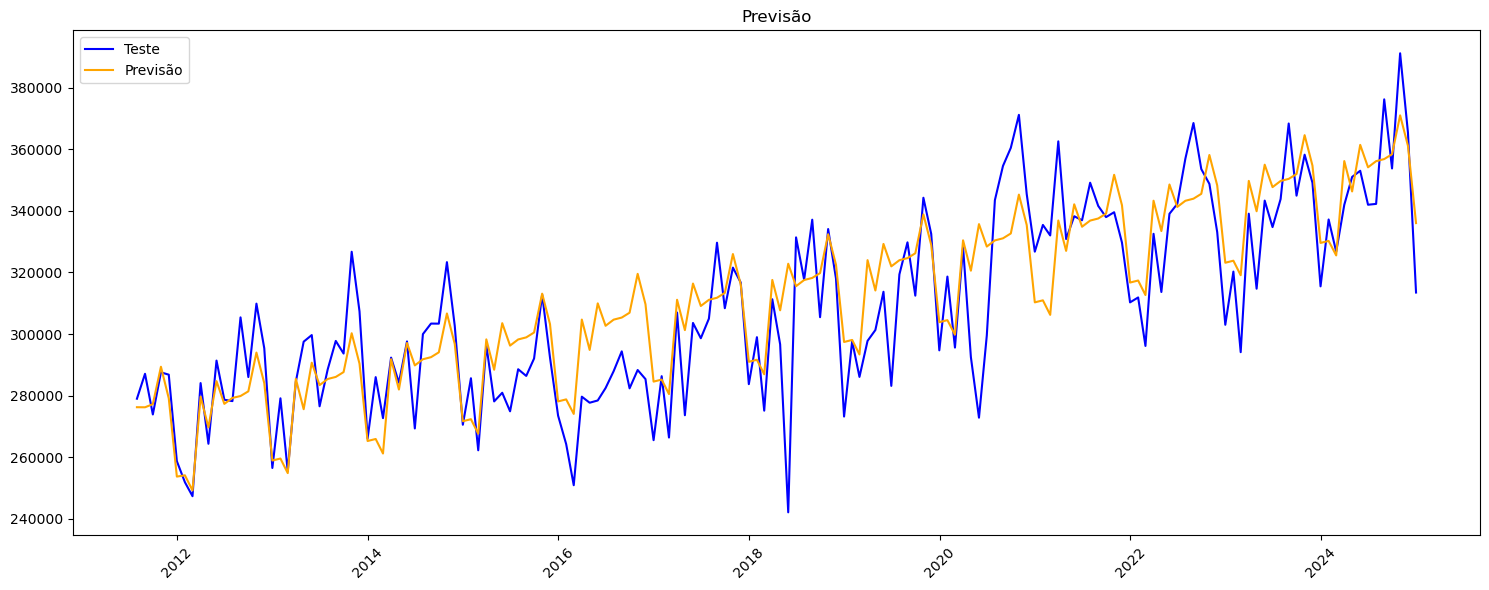

In [71]:
# Valores Reais X Previsões

plt.figure(figsize=(15, 6))
plt.plot(x_test, label='Teste', color='blue')
plt.plot(previsao, label='Previsão', color='orange')
plt.legend()
plt.title('Previsão')
plt.xticks(rotation=45)  # Rotaciona as datas para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar cortes nas labels
plt.show()

In [101]:
# Previsão para o perído de treino 

order = modelo.order
seasonal_order = modelo.seasonal_order
    
# Ajustar o modelo SARIMAX
modelo_sarimax = SARIMAX(
    x_train, 
    order=order, 
    seasonal_order=seasonal_order).fit(disp=0)

# Exibir os melhores parâmetros
print(modelo_sarimax.summary())

# Obter as previsões em níveis
predito = modelo_sarimax.predict(typ='levels')

                                      SARIMAX Results                                       
Dep. Variable:                     Produção Papelão   No. Observations:                  378
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood               -3873.046
Date:                              Sun, 31 Aug 2025   AIC                           7754.092
Time:                                      19:01:59   BIC                           7769.703
Sample:                                  01-31-1980   HQIC                          7760.296
                                       - 06-30-2011                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8994      0.053     16.988      0.000       0.796       1.003
ar.L2          0.01

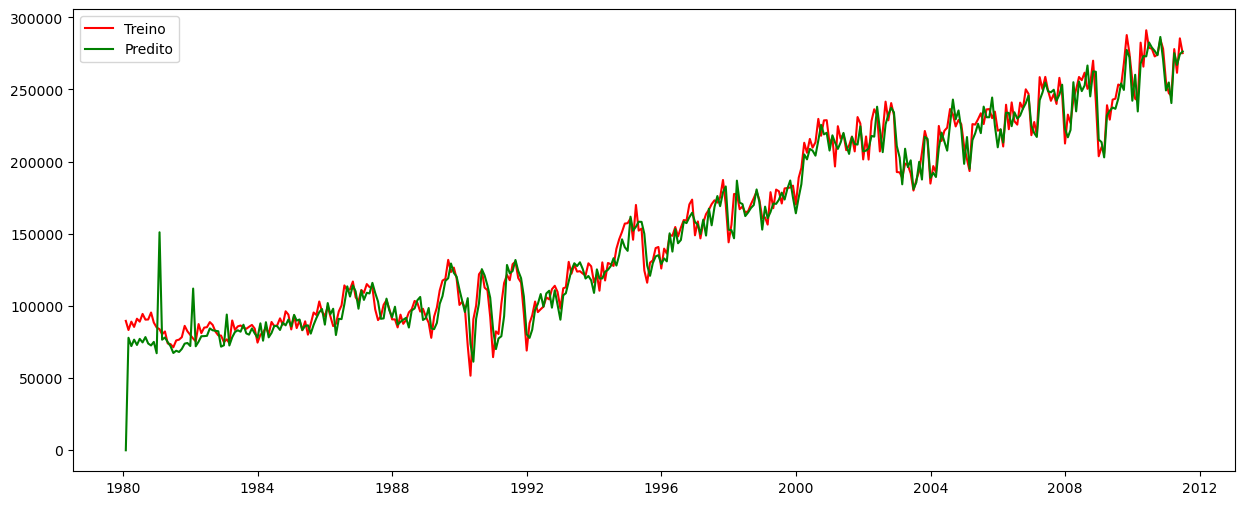

In [103]:
# Plotar a série original e as previsões
plt.plot(x_train, color='red', label='Treino')  # Série original
plt.plot(predito, color='green', label='Predito')  # Previsões do modelo
plt.legend()
plt.show()

In [105]:
# Métricas para o período de teste

print("RMSE do modelo (teste vs previsões): %.3f" % np.sqrt(mean_squared_error(x_test , previsao)))
print("MAPE do modelo (teste vs previsões): %.3f" %mean_absolute_percentage_error(x_test , previsao))
print("MAE do modelo (teste vs previsões): %.3f" % mean_absolute_error(x_test , previsao))
print("R² do modelo (teste vs previsões): %.3f" % r2_score(x_test, previsao))

RMSE do modelo (teste vs previsões): 16385.673
MAPE do modelo (teste vs previsões): 0.041
MAE do modelo (teste vs previsões): 12338.768
R² do modelo (teste vs previsões): 0.713


In [107]:
 # Métricas para o período de treino

print("RMSE do modelo (treino vs treinado): %.3f" % np.sqrt(mean_squared_error(x_train , predito)))
print("MAPE do modelo (treino vs treinado): %.3f" %mean_absolute_percentage_error(x_train , predito))
print("MAE do modelo (treino vs treinado): %.3f" % mean_absolute_error(x_train , predito))
print("R² do modelo (treino vs treinado): %.3f" % r2_score(x_train, predito))  

RMSE do modelo (treino vs treinado): 10917.501
MAPE do modelo (treino vs treinado): 0.060
MAE do modelo (treino vs treinado): 7700.685
R² do modelo (treino vs treinado): 0.971


In [111]:
modelo.fit(papelao)

previsao2 = modelo.predict(n_periods=12)

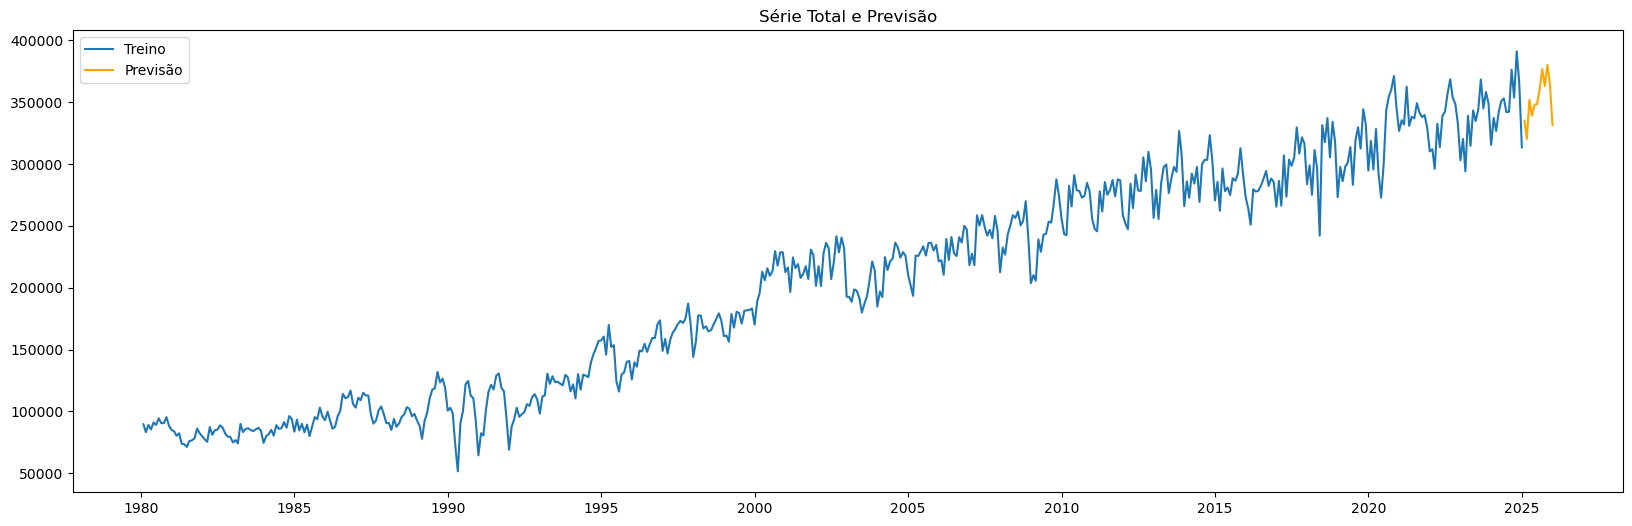

In [124]:
# Plotando as previsões no nível original junto com a série de treino e teste
plt.figure(figsize=(20, 6))
plt.plot(papelao, label='Treino')
plt.plot(previsao2, label='Previsão', color='orange')
plt.legend()
plt.title('Série Total e Previsão')
#plt.grid(True)
plt.show()   

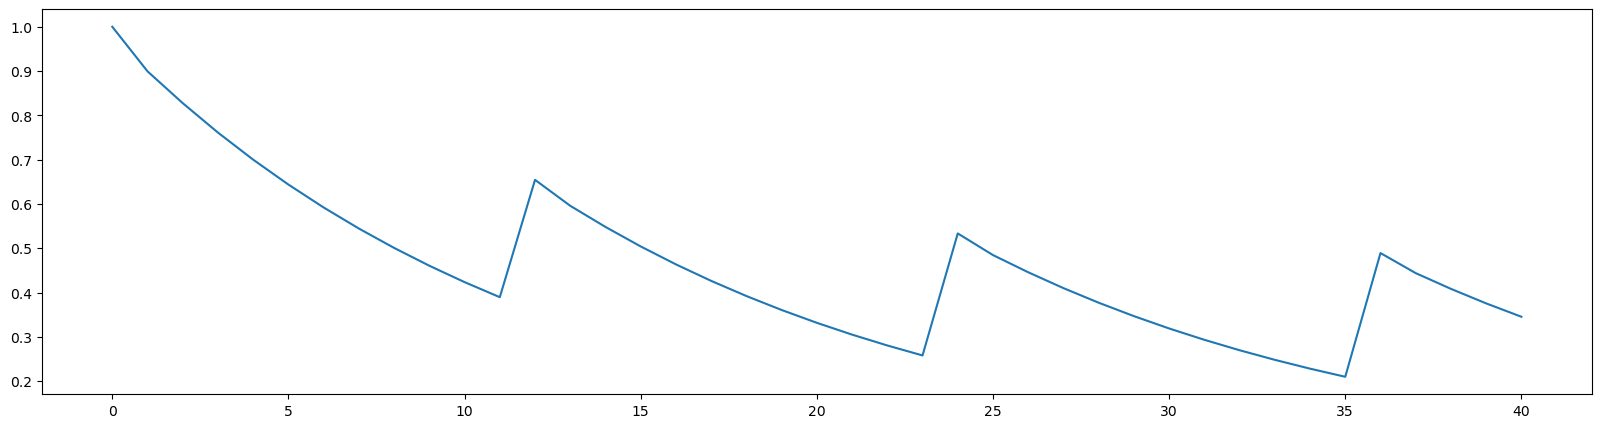

In [115]:
# medindo o impcato da variável na propria séire.

modelo_sarimax.impulse_responses(steps=40).plot(figsize=(20,5));

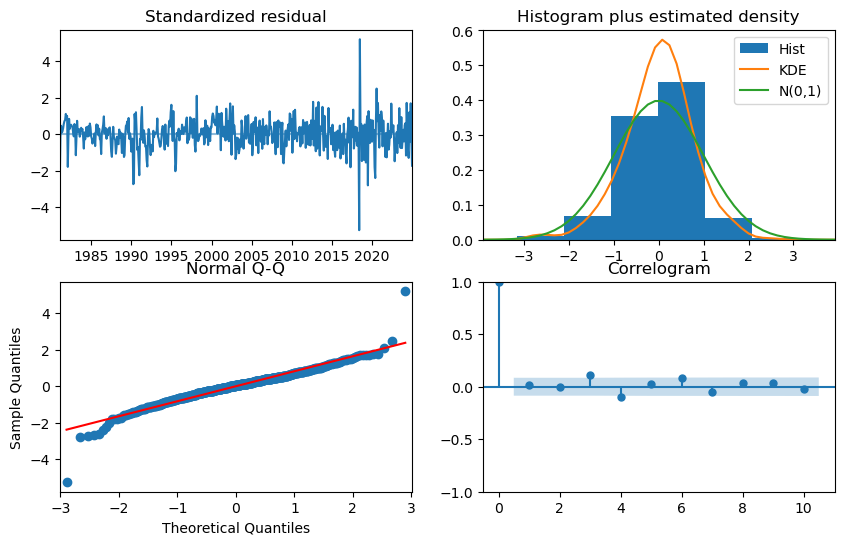

In [79]:
#  Usando o plot_diagnostic para obsevar os resíduos, o histograma dos resíduos, o gráfico QQ e o correlograma dos resíduos.

modelo.plot_diagnostics(figsize=(10,6));

In [80]:
# Analisando o desempenho para 2025

papelao_2025 = data.loc['2025-01-01':'2025-07-31']
papelao_2025

2025-01-31    335067.0
2025-02-28    322676.0
2025-03-31    346610.0
2025-04-30    340025.0
2025-05-31    360612.0
2025-06-30    338545.0
2025-07-31    378902.0
Freq: ME, dtype: float64

In [81]:
previsao_2025 = previsao2.loc['2025-01-01':'2025-07-31']
previsao_2025

2025-01-31    335031.774519
2025-02-28    320301.641618
2025-03-31    351935.198540
2025-04-30    339044.710777
2025-05-31    347962.046013
2025-06-30    348465.278661
2025-07-31    360731.452426
Freq: ME, dtype: float64

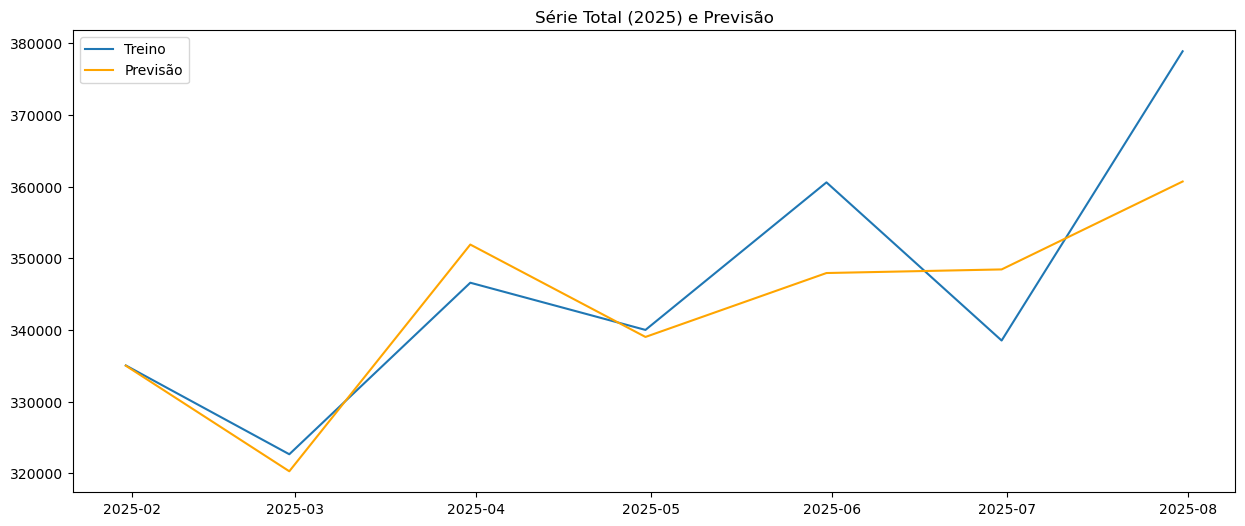

In [126]:
# Plotando para o ano de 2025

plt.figure(figsize=(15, 6))
plt.plot(papelao_2025, label='Treino')
plt.plot(previsao_2025, label='Previsão', color='orange')
plt.legend()
plt.title('Série Total (2025) e Previsão')
#plt.grid(True)
plt.show()   